In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

In [105]:
# Load original Planetoid Cora dataset
dataset = Planetoid(root='cora', name='Cora', split='public')
data = dataset[0]

G_original = to_networkx(data, to_undirected=True)
print(f"Original Graph: {G_original.number_of_nodes()} nodes, {G_original.number_of_edges()} edges")

Original Graph: 2708 nodes, 5278 edges


### Perturbed sonia attack

In [106]:
# Load perturbed graph from perturbed_content.csv and perturbed_edges.csv
perturbed_edges = pd.read_csv('data/cora/perturbed/perturbed_edges.csv', header=None, names=['src', 'dst'])

G_perturbed = nx.Graph()
G_perturbed.add_edges_from(perturbed_edges.values)
print(f"Perturbed Graph: {G_perturbed.number_of_nodes()} nodes, {G_perturbed.number_of_edges()} edges")

Perturbed Graph: 2707 nodes, 5278 edges


### Perturbed Nettack

In [101]:
import torch
import networkx as nx

# Load the file
data_2 = torch.load('Cora_perturbed.pt')

# Extract adjacency matrix
adj = data_2['perturbed_adj']

# If it's a sparse tensor, convert it to edge list
if adj.is_sparse:
    # Get indices (edges) from the sparse tensor
    edge_index = adj.coalesce().indices()
    edge_list = edge_index.t().tolist()
else:
    # If it's a dense tensor, convert to edge list by finding non-zero entries
    edge_list = adj.nonzero(as_tuple=False).tolist()

# Build the graph
G_perturbed = nx.Graph()
G_perturbed.add_edges_from(edge_list)

print(f"Perturbed Graph: {G_perturbed.number_of_nodes()} nodes, {G_perturbed.number_of_edges()} edges")

# Return G_perturbed
G_perturbed


Perturbed Graph: 2708 nodes, 5283 edges


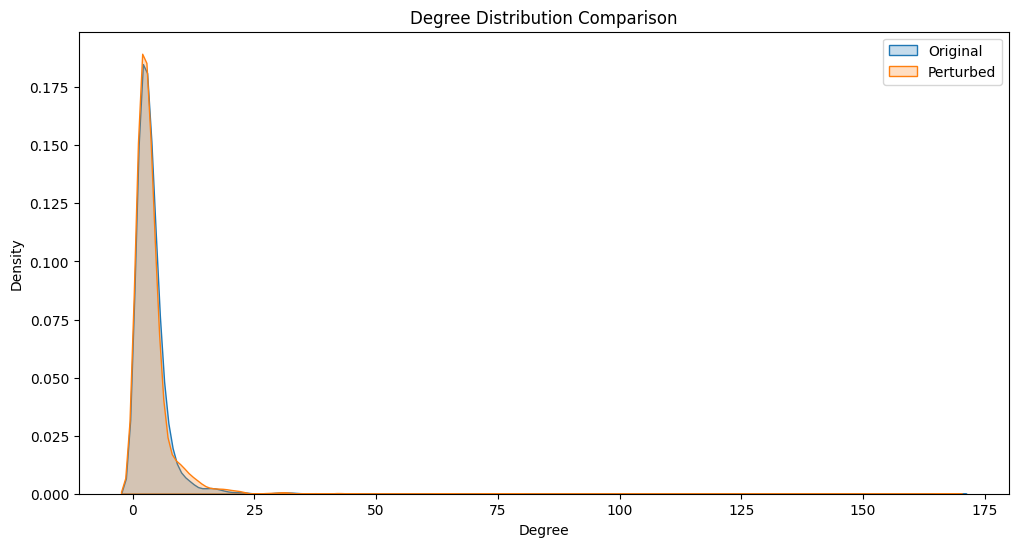

In [107]:
# Compute degrees
deg_orig = [d for n, d in G_original.degree()]
deg_pert = [d for n, d in G_perturbed.degree()]

# Plot
plt.figure(figsize=(12,6))
sns.kdeplot(deg_orig, label="Original", fill=True)
sns.kdeplot(deg_pert, label="Perturbed", fill=True)
plt.title("Degree Distribution Comparison")
plt.xlabel("Degree")
plt.ylabel("Density")
plt.legend()

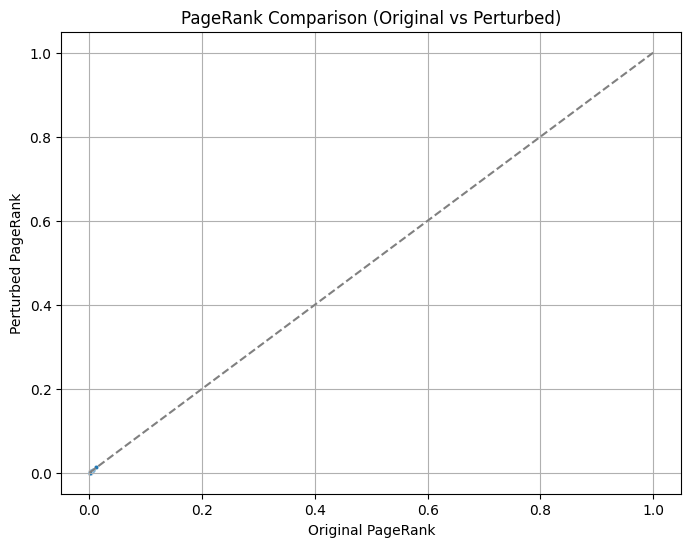

In [108]:
pr_orig = nx.pagerank(G_original)
pr_pert = nx.pagerank(G_perturbed)

# Merge PageRank into a dataframe
pr_df = pd.DataFrame({
    'Original': pd.Series(pr_orig),
    'Perturbed': pd.Series(pr_pert)
})

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Original', y='Perturbed', data=pr_df, s=10)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("PageRank Comparison (Original vs Perturbed)")
plt.xlabel("Original PageRank")
plt.ylabel("Perturbed PageRank")
plt.grid(True)
plt.show()

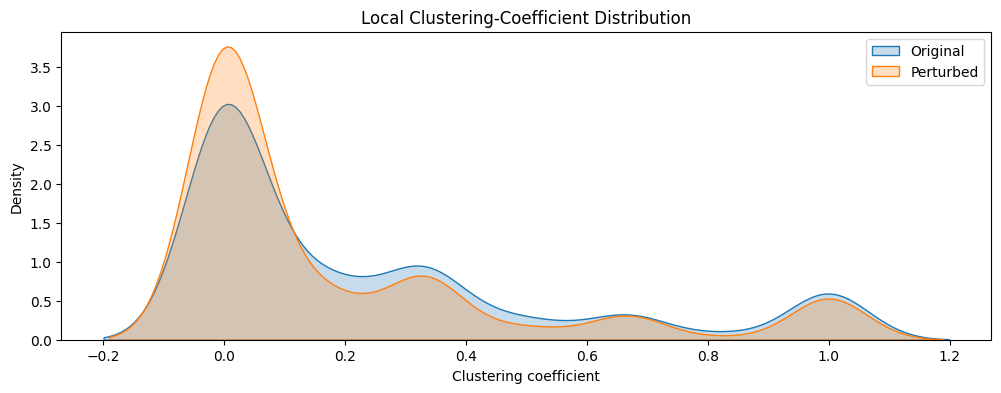

Global C_orig  = 0.2407
Global C_pert  = 0.1955


In [109]:
# --- Clustering coefficient -----------------------------------
cc_orig  = list(nx.clustering(G_original).values())
cc_pert  = list(nx.clustering(G_perturbed).values())

plt.figure(figsize=(12,4))
sns.kdeplot(cc_orig, label="Original", fill=True)
sns.kdeplot(cc_pert, label="Perturbed", fill=True)
plt.title("Local Clustering-Coefficient Distribution")
plt.xlabel("Clustering coefficient"); plt.legend(); plt.show()

print(f"Global C_orig  = {nx.average_clustering(G_original):.4f}")
print(f"Global C_pert  = {nx.average_clustering(G_perturbed):.4f}")

In [110]:
label_dict = data.y.numpy()  # labels from torch-geo
nx.set_node_attributes(G_original,  {i:int(label_dict[i]) for i in G_original}, 'y')
nx.set_node_attributes(G_perturbed,{i:int(label_dict[i]) for i in G_perturbed},'y')

r_orig = nx.attribute_assortativity_coefficient(G_original, 'y')
r_pert = nx.attribute_assortativity_coefficient(G_perturbed,'y')
print(f"Label assortativity:  orig={r_orig:.4f}   pert={r_pert:.4f}")


Label assortativity:  orig=0.7711   pert=0.6570


In [111]:
# Ensure label array is in NumPy format
labels = data_2['labels']
if isinstance(labels, torch.Tensor):
    label_array = labels.numpy()
elif isinstance(labels, np.ndarray):
    label_array = labels
else:
    raise TypeError("Unsupported label type")

# Assign labels as node attributes
nx.set_node_attributes(G_original,  {i: int(label_array[i]) for i in G_original.nodes}, 'y')
nx.set_node_attributes(G_perturbed, {i: int(label_array[i]) for i in G_perturbed.nodes}, 'y')

# Compute label assortativity
r_orig = nx.attribute_assortativity_coefficient(G_original, 'y')
r_pert = nx.attribute_assortativity_coefficient(G_perturbed, 'y')

print(f"Label assortativity:  orig={r_orig:.4f}   pert={r_pert:.4f}")



Label assortativity:  orig=0.7711   pert=0.6570


Nodes with largest betweenness change: [1986, 2034, 1072, 1013, 2249, 2130, 1701, 306, 1358, 109]


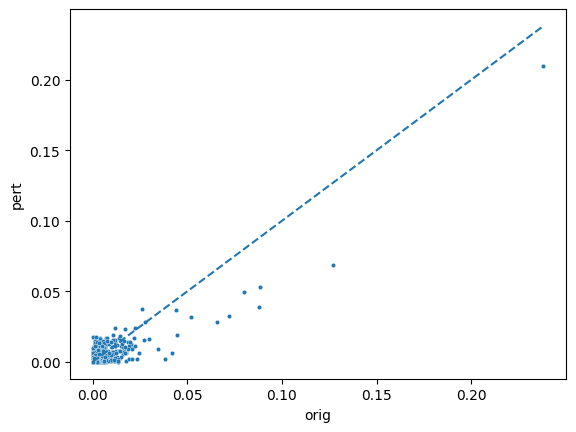

In [112]:
btw_o = nx.betweenness_centrality(G_original, k=500, seed=1)   # sample for speed
btw_p = nx.betweenness_centrality(G_perturbed, k=500, seed=1)

df_btw = pd.DataFrame({'orig':btw_o, 'pert':btw_p})
df_btw['delta'] = df_btw['pert'] - df_btw['orig']
top_shift = df_btw['delta'].abs().nlargest(10).index

print("Nodes with largest betweenness change:", top_shift.tolist())
sns.scatterplot(x='orig', y='pert', data=df_btw, s=10)
plt.plot([0, max(df_btw.max())], [0, max(df_btw.max())],'--'); plt.show()

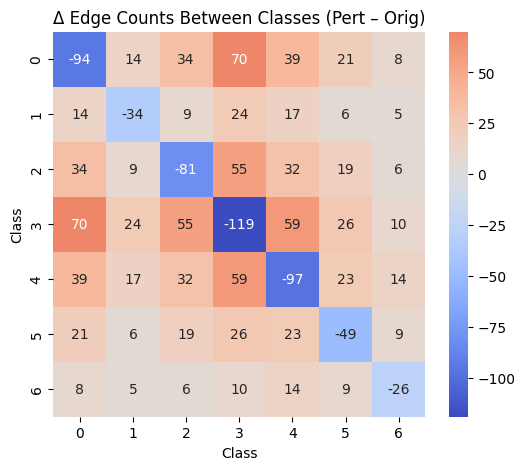

In [113]:
def class_mix(G, labels):
    m = len(np.unique(labels))
    M = np.zeros((m,m), dtype=int)
    for u,v in G.edges():
        M[labels[u], labels[v]] += 1
        if labels[u]!=labels[v]:
            M[labels[v], labels[u]] += 1
    return M

mix_o = class_mix(G_original, label_dict)
mix_p = class_mix(G_perturbed, label_dict)

delta = mix_p - mix_o
plt.figure(figsize=(6,5))
sns.heatmap(delta, cmap='coolwarm', center=0, annot=True, fmt='d')
plt.title("Δ Edge Counts Between Classes (Pert – Orig)")
plt.xlabel("Class"); plt.ylabel("Class"); plt.show()


In [114]:
def get_lcc(G):
    """Return the subgraph induced by the largest connected component."""
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

G0_lcc = get_lcc(G_original)
Gp_lcc = get_lcc(G_perturbed)

def approx_dist_stats(G, k=2000, seed=42):
    rng   = np.random.RandomState(seed)
    nodes = list(G.nodes())
    pairs = [tuple(rng.choice(nodes, 2, replace=False)) for _ in range(k)]
    dists = [nx.shortest_path_length(G, *p) for p in pairs]
    return np.mean(dists), np.percentile(dists, 95)

avg_o, p95_o = approx_dist_stats(G0_lcc)
avg_p, p95_p = approx_dist_stats(Gp_lcc)

print(f"LCC - mean dist  : orig={avg_o:.2f}  pert={avg_p:.2f}")
print(f"LCC - 95-percent.: orig={p95_o:.2f}  pert={p95_p:.2f}")

LCC - mean dist  : orig=6.28  pert=5.29
LCC - 95-percent.: orig=10.00  pert=8.00


In [115]:
def approx_dist_stats_skip(G, k=2000, seed=42):
    rng   = np.random.RandomState(seed)
    nodes = list(G.nodes())
    dists = []
    while len(dists) < k:
        u, v = rng.choice(nodes, 2, replace=False)
        try:
            dists.append(nx.shortest_path_length(G, u, v))
        except nx.NetworkXNoPath:
            continue        # just resample
    return np.mean(dists), np.percentile(dists, 95)

avg_o, p95_o = approx_dist_stats_skip(G_original)
avg_p, p95_p = approx_dist_stats_skip(G_perturbed)
print(f"Mean shortest-path (skip): orig={avg_o:.2f}  pert={avg_p:.2f}")

Mean shortest-path (skip): orig=6.36  pert=5.22


In [116]:
def approx_dist_stats_inf(G, k=2000, seed=42, inf=1e9):
    rng   = np.random.RandomState(seed)
    nodes = list(G.nodes())
    pairs = [tuple(rng.choice(nodes, 2, replace=False)) for _ in range(k)]
    d = []
    for u, v in pairs:
        try:
            d.append(nx.shortest_path_length(G, u, v))
        except nx.NetworkXNoPath:
            d.append(inf)
    return np.mean(d), np.percentile(d, 95)

avg_o, p95_o = approx_dist_stats_inf(G_original)
avg_p, p95_p = approx_dist_stats_inf(G_perturbed)
print(f"Mean shortest-path (∞): orig={avg_o:.2f}  pert={avg_p:.2f}")


Mean shortest-path (∞): orig=157500005.38  pert=132000004.53


In [117]:
# ---------------------------------------------------------------
# Betweenness centrality comparison (original vs perturbed)
# ---------------------------------------------------------------
import time
from tqdm.auto import tqdm

# ► 1) choose fast sampling or full exact computation
SAMPLE = 800        # set to None to compute exact betweenness for every node
SEED   = 1

def betweenness(G, sample=None, seed=SEED):
    if sample is None:
        return nx.betweenness_centrality(G, normalized=True)
    rng   = np.random.default_rng(seed)
    nodes = rng.choice(list(G.nodes()), size=sample, replace=False)
    return nx.betweenness_centrality(G, k=sample, normalized=True, seed=seed)

print("Computing betweenness …")
btw_orig = betweenness(G_original,  SAMPLE)
btw_pert = betweenness(G_perturbed, SAMPLE)

Computing betweenness …


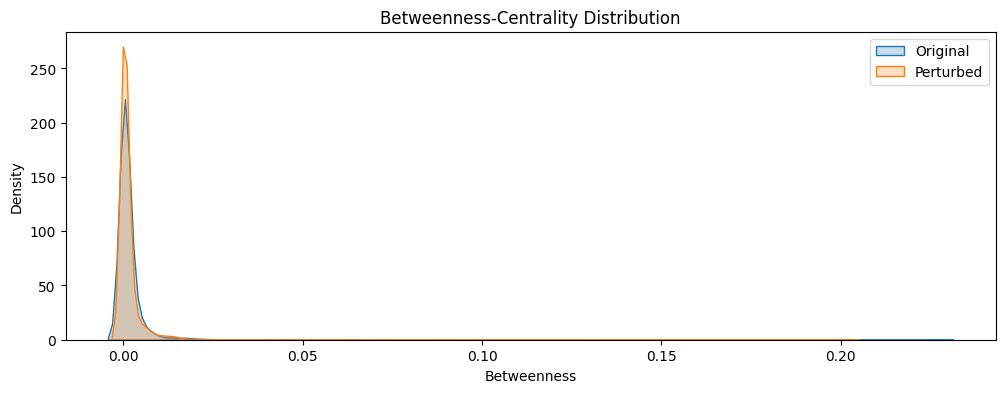

In [118]:

# ► 2) turn into 1-D arrays (aligned by node id)
orig_vals = np.array([btw_orig[n] for n in sorted(btw_orig)])
pert_vals = np.array([btw_pert[n] for n in sorted(btw_pert)])

# KDE plot ------------------------------------------------------
plt.figure(figsize=(12,4))
sns.kdeplot(orig_vals,  label="Original",  fill=True)
sns.kdeplot(pert_vals, label="Perturbed", fill=True)
plt.title("Betweenness-Centrality Distribution")
plt.xlabel("Betweenness"); plt.ylabel("Density"); plt.legend(); plt.show()

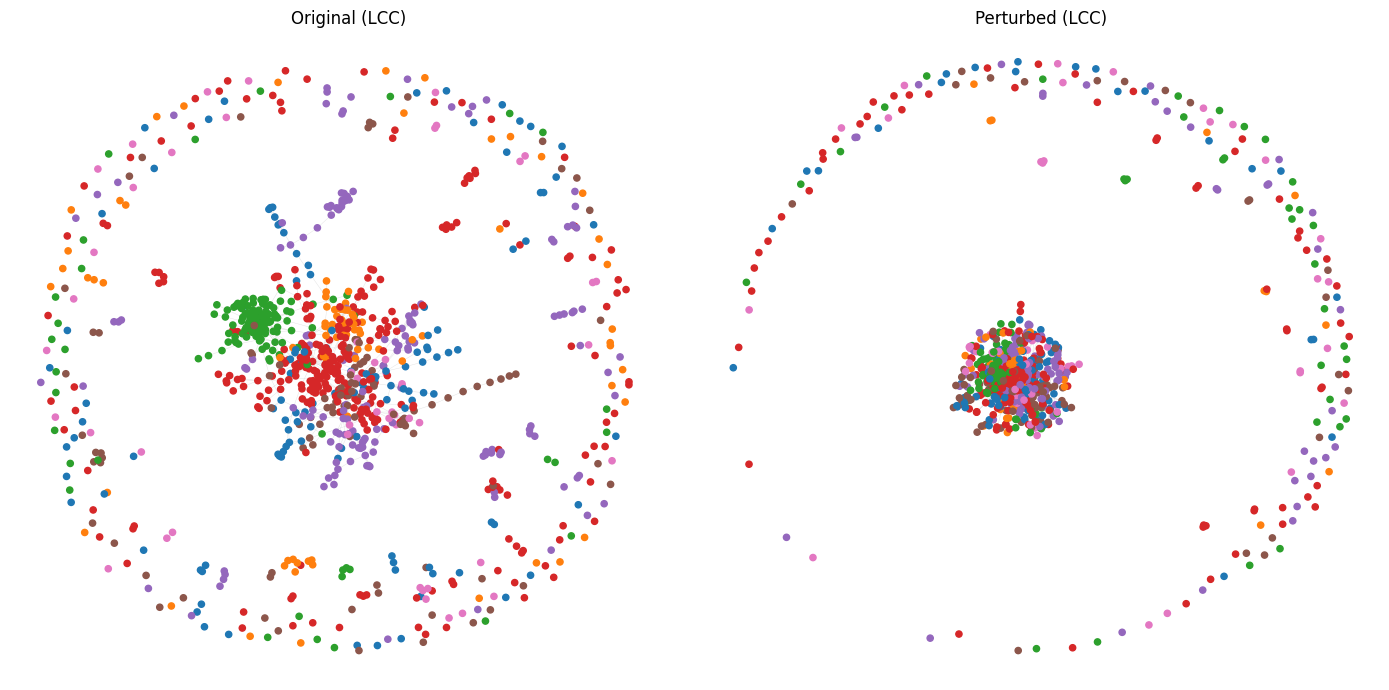

In [119]:
# Load original Planetoid Cora dataset
dataset = Planetoid(root='cora', name='Cora', split='public')
data = dataset[0]

G_original = nx.Graph()
edge_index = data.edge_index.numpy()
G_original.add_edges_from(edge_index.T)
labels = data.y.numpy()

# Load perturbed graph
perturbed_edges = pd.read_csv('data/cora/perturbed/perturbed_edges.csv', header=None, names=['src', 'dst'])
G_perturbed = nx.Graph()
G_perturbed.add_edges_from(perturbed_edges.values)

def sample_graph(G, n=None, seed=1):
    if n is None or n >= G.number_of_nodes():
        return G
    rng = np.random.default_rng(seed)
    keep = rng.choice(list(G.nodes()), size=n, replace=False)
    return G.subgraph(keep).copy()


# Prepare largest components
def lcc(G):
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

G0 = lcc(G_original)
Gp = lcc(G_perturbed)
SUBSAMPLE = 1000
G0_draw = sample_graph(G0, SUBSAMPLE)
Gp_draw = sample_graph(Gp, SUBSAMPLE)

# Compute layout on original
pos = nx.spring_layout(G0_draw, seed=42)

# Patch layout for missing nodes in perturbed graph
missing = [n for n in Gp_draw if n not in pos]
if missing:
    pos_extra = nx.spring_layout(Gp_draw, seed=42, pos=pos, fixed=pos.keys())
    pos_p = {**pos, **{n: pos_extra[n] for n in missing}}
else:
    pos_p = pos

# Color nodes by class label
palette = plt.cm.tab10
def node_colors(nodes):
    return [palette(labels[n] % 10) for n in nodes]

# Draw side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, G, title, this_pos in [
        (axes[0], G0_draw, "Original (LCC)", pos),
        (axes[1], Gp_draw, "Perturbed (LCC)", pos_p)]:

    nx.draw_networkx_nodes(G, this_pos,
                           node_size=20,
                           node_color=node_colors(G.nodes()),
                           ax=ax)
    nx.draw_networkx_edges(G, this_pos,
                           width=0.3,
                           edge_color="lightgray",
                           alpha=0.7,
                           ax=ax)
    ax.set_title(title); ax.set_axis_off()

plt.tight_layout()

plt.show()


def sample_graph(G, n=None, seed=1):
    if n is None or n >= G.number_of_nodes():
        return G
    rng = np.random.default_rng(seed)
    keep = rng.choice(list(G.nodes()), size=n, replace=False)
    return G.subgraph(keep).copy()
